# Access NOAA's SONAR data hosted on AWS via OSDF protocol
- For more information using the dataset, see https://cires.gitbook.io/ncei-wcsd-archive
- This notebook is heavily inspried by the google colab notebook https://colab.research.google.com/drive/1-I56QOIftj9sewlbyzTzncdRt54Fh51d?usp=sharing#scrollTo=bCG81-1XOGqc
- In this notebook, we will use the osdf protocol to access data from a zarr store via PelicanFS.
- We will access the data using OSDF's AWS open data origin.
- For more details about pelicanfs, see https://github.com/PelicanPlatform/pelicanfs

## Overview 
- The size and physiological characteristics of marine organisms determine their reflectance properties. An organisms backscatter also depends on the sonar frequency. Frequency differencing of the sonar's volume backscattering strength (Sv) called "dB differencing" is a common analysis technique to help differentiate sources of acoustic scatterers.
- This notebook demonstrates the use of frequency differencing on some Level 2 EK60 data.
- The Level 2 data can be found here:
https://noaa-wcsd-zarr-pds.s3.us-east-1.amazonaws.com/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/
- The files can be explored by navigating to the following AWS file explorer:
https://noaa-wcsd-zarr-pds.s3.amazonaws.com/index.html#level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr/

#### Import package, define parameters and functions

In [44]:
# Display output of plots directly in Notebook
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import intake
import numpy as np
import pandas as pd
import xarray as xr
import s3fs
import seaborn as sns
import re
import nest_asyncio
nest_asyncio.apply()

In [8]:
from pelicanfs.core import PelicanFileSystem, PelicanMap,OSDFFileSystem 
import fsspec.implementations.http as fshttp

In [9]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

## Use OSDF protocol to access data

### Set up osdf url to use with PelicanFS
- We should one of the two pelicanFS FSSpec protocols ('osdf' or 'pelican') instead of the https protocol.
- So, the urls will look like: osdf_discovery_url + namespace prefix/aws_region/bucket_name/path to file or object
- osdf_discovery_url = osdf:///, namespace_prefix = aws-opendata
- aws_region = us-east-1, bucket_name = 'noaa-wcsd-zarr-pds'
- zarr_store = 'level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr'
- An example url:
- osdf:///us-east-1/aws-opendata/noaa-wcsd-zarr-pds/evel_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr

In [10]:
%%time
pelfs = OSDFFileSystem() # OSDFFileSystem is already aware of the osdf discovery url

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 3.22 ms


In [15]:
%%time
# Compose url using s3 protocol
bucket_name = 'noaa-wcsd-zarr-pds'

ship_name   = 'Bell_M._Shimada'
cruise_name = 'SH1507'
sensor_name = 'EK60'

zarr_store = f'{cruise_name}.zarr'

# How an s3 path would look 
s3_zarr_store_path = f"{bucket_name}/level_2/{ship_name}/{cruise_name}/{sensor_name}/{zarr_store}"
print(s3_zarr_store_path)

noaa-wcsd-zarr-pds/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr
CPU times: user 60 μs, sys: 0 ns, total: 60 μs
Wall time: 62.7 μs


In [18]:
# Compose url using OSDF protocol
namespace_prefix = 'aws-opendata'
aws_region       = 'us-east-1'
osdf_path        = f"{namespace_prefix}/{aws_region}/{s3_zarr_store_path}"
print(osdf_path)

# This just prepends the osdf_disovery_url to the osdf_path
osdf_zarr_store_path = PelicanMap(osdf_path, pelfs)

aws-opendata/us-east-1/noaa-wcsd-zarr-pds/level_2/Bell_M._Shimada/SH1507/EK60/SH1507.zarr


#### Opening a Zarr store with Xarray

We will open the S3 Zarr store using Xarray (the "consolidated" parameter just defines whether we are interested in reading the metadata in a consolidated manner, "None" is the desired value).

In [34]:
# %%time
# # First use s3
# s3_file_system = s3fs.S3FileSystem(anon=True)
# store          = s3fs.S3Map(root=s3_zarr_store_path, s3=s3_file_system, check=False)
# cruise         = xr.open_zarr(store=store, consolidated=None)

In [33]:
%%time
# Now use OSDF protocol: 
# It is not necessary to add 'osdf:/// explicitly like this. The following should also work
# cruise_osdf = xr.open_zarr(osdf_zarr_store_path,consolidated = None)
cruise_osdf = xr.open_zarr('osdf:///'+ osdf_path,consolidated = None)
cruise_osdf

CPU times: user 27.8 ms, sys: 338 μs, total: 28.2 ms
Wall time: 221 ms


<xarray.Dataset> Size: 181MB
Dimensions:    (depth: 2800, time: 3234, frequency: 5)
Coordinates:
  * depth      (depth) float64 22kB nan 0.25 0.5 0.75 ... 699.5 699.8 700.0
  * frequency  (frequency) float32 20B 1.8e+04 3.8e+04 7e+04 1.2e+05 2e+05
  * time       (time) datetime64[ns] 26kB 2015-07-19T19:08:39.063712768 ... 2...
Data variables:
    Sv         (depth, time, frequency) float32 181MB dask.array<chunksize=(512, 512, 1), meta=np.ndarray>
    latitude   (time) float32 13kB dask.array<chunksize=(512,), meta=np.ndarray>
    longitude  (time) float32 13kB dask.array<chunksize=(512,), meta=np.ndarray>
Attributes:
    processing_software_name:     echofish
    processing_software_version:  0.0.1
    processing_time:              2023-10-01T18:08:01Z

### Load data and plot echogram

Subsetting on one hour worth of data near an area of interest. We'll define select_times from 19:00 to 20:00 on July 19th 2015.

In [26]:
# roughly covering the raw files from SaKe2015-D20150719-T193412.raw to SaKe2015-D20150719-T195842.raw
start_time = np.datetime64('2015-07-19T19:00:00')
end_time = np.datetime64('2015-07-19T20:00:00')

select_times = (cruise_osdf.time > start_time) & (cruise_osdf.time < end_time)

We can then use this slice of select_times to select the Sv values for the specific subset of time. Additional subsetting can also be added to the query, for example we can additionally subset by defining a selected frequency. The example below selects 18 kHz for the time interval of interest and store this in Sv_18 (drop=True means that the coordinate labels that do not meet the condition are not just masked but also dropped from the result)

In [28]:
Sv_38 = cruise_osdf.sel(frequency=38000).where((select_times), drop=True).Sv
print(Sv_38)

<xarray.DataArray 'Sv' (depth: 2800, time: 2959)> Size: 33MB
dask.array<where, shape=(2800, 2959), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float64 22kB nan 0.25 0.5 0.75 ... 699.5 699.8 700.0
    frequency  float32 4B 3.8e+04
  * time       (time) datetime64[ns] 24kB 2015-07-19T19:08:39.063712768 ... 2...
Attributes:
    long_name:  Volume backscattering strength (Sv re 1 m-1)
    units:      dB


CPU times: user 865 ms, sys: 133 ms, total: 998 ms
Wall time: 3.23 s


Text(0.5, 1.0, 'Sv 38 kHz')

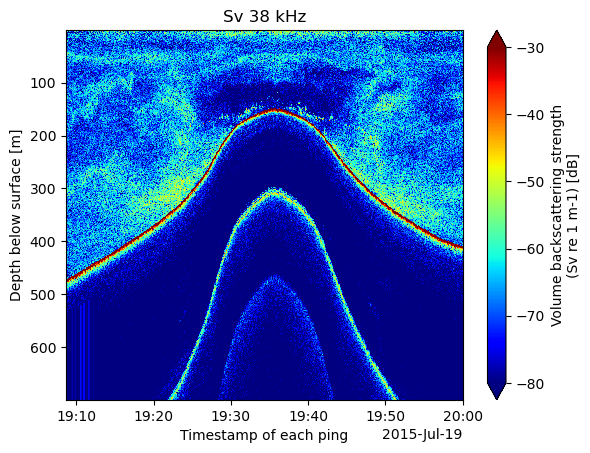

In [31]:
%%time
Sv_38.dropna(dim='depth').plot(yincrease=False, cmap='jet', vmin=-80, vmax=-30)

plt.title(f"Sv 38 kHz")

The data in the plot above shows a detected bottom as a ship crosses above a smooth ridge. Beneath the seabed are two harmonics we would like to omit from the plot. We can begin to do that by just plotting data between 0 and 500 meters of depth.

In [37]:
start_depth = 0
end_depth = 500

select_depths = (cruise_osdf.depth > start_depth) & (cruise_osdf.depth < end_depth)

In [38]:
Sv_38_subset = Sv_38.where((select_depths), drop=True)

Now when we plot the data it is subsetted to less than 500 meters of depth.

Text(0.5, 1.0, 'Sv 38 kHz')

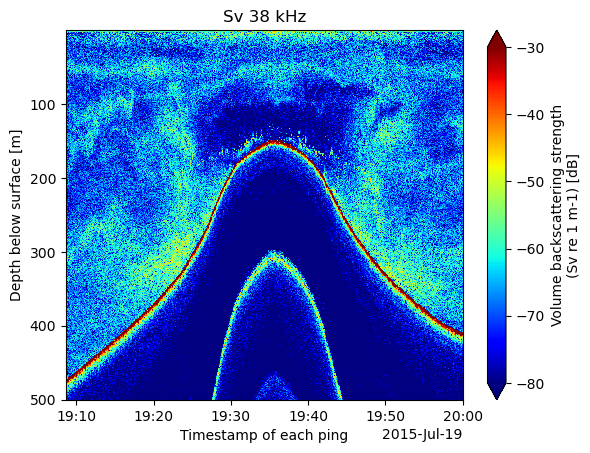

In [39]:
%%time
Sv_38_subset.plot(yincrease=False, cmap='jet', vmin=-80, vmax=-30)
plt.title(f"Sv 38 kHz")

We can also select the corresponding data for 120 and 200 kHz and store them in seperate variables

In [41]:
Sv_18 = cruise_osdf.sel(frequency=18000).where((select_times) & (select_depths), drop=True).Sv
Sv_120 = cruise_osdf.sel(frequency=120000).where((select_times) & (select_depths), drop=True).Sv
Sv_200 = cruise_osdf.sel(frequency=200000).where((select_times) & (select_depths), drop=True).Sv

For comparison, let's see the 120 kHz echogram with the same depth bounds.

In [42]:
Sv_120_subset = Sv_120.where((select_depths), drop=True)

Text(0.5, 1.0, 'Sv 120 kHz')

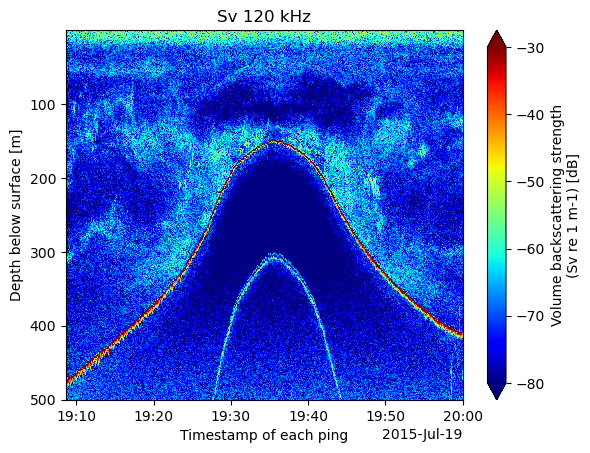

In [43]:
%%time
Sv_120_subset.plot(yincrease=False, cmap='jet', vmin=-80, vmax=-30)
plt.title(f"Sv 120 kHz")